# Predicting Apple Stock Price using Long Short-Term Memory (LSTM)
Author : Nishaal Ajmera

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
import math

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

## Getting the data

In [14]:
# Select ticker 
ticker = 'AAPL' 
start = dt.datetime(2000,1,1)
end = dt.datetime(2022,1,1)

ticker_instance = yf.Ticker(ticker)
stock_data = ticker_instance.history(start = start, end = end)

# Subset data by close price
all_data = stock_data['Close'].values
all_data = all_data.reshape(-1,1)


## Preparing Data

In [15]:
# Prepare training data
training_data_len = math.ceil(len(all_data)* 0.8)

# Standardise the data
scaler = MinMaxScaler(feature_range = (0,1))

train_data = scaler.fit_transform(all_data[0: training_data_len, :])

prediction_days = 60

x_train = []
y_train = []

for i in range(prediction_days, len(train_data)):
    x_train.append(train_data[i - prediction_days : i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Prepare test data

test_data = scaler.transform(all_data[training_data_len - prediction_days : , : ])


x_test = []
y_test = stock_data["Close"].values[training_data_len:]

for i in range(prediction_days, len(test_data)):
  x_test.append(test_data[i - prediction_days : i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

## LSTM Model 

In [16]:
# LSTM model 
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units =50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

print(model.summary())

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train,y_train,epochs =25, batch_size=32)

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

lstm_rmse = np.sqrt(np.mean(predicted_prices - y_test)**2)
print("RMSE Lstm:", lstm_rmse)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_7 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

## Results Visualisation

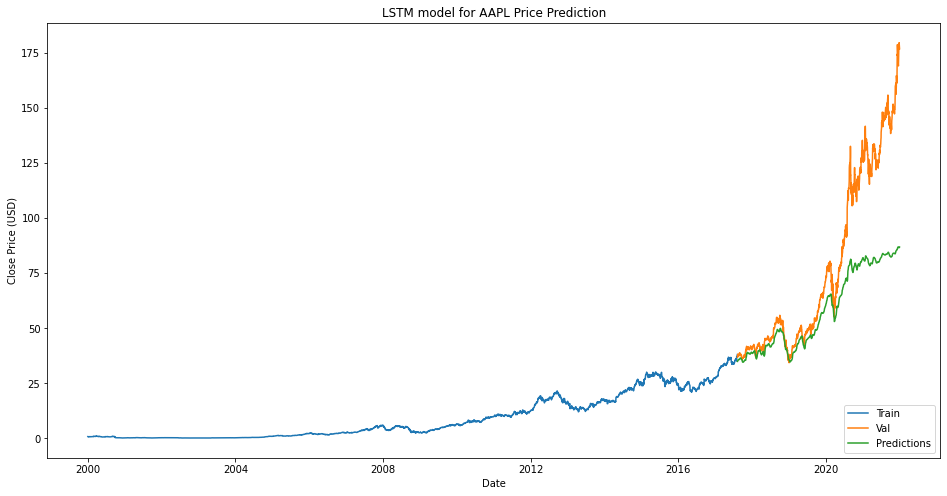

In [17]:
visual_data = stock_data.filter(['Close'])
train = visual_data[:training_data_len].copy()
validation = visual_data[training_data_len:].copy()
validation['Predictions'] = predicted_prices
plt.figure(figsize=(16,8))
plt.title(f"LSTM model for {ticker} Price Prediction")
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()